In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import warnings
import cv2
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
warnings.filterwarnings('ignore')
import visualkeras

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
# Generating train dataset
data = keras.preprocessing.image_dataset_from_directory(directory = 'dataset',
                                                   color_mode = 'rgb',
                                                   batch_size = 64,
                                                   image_size = (224,224),
                                                   shuffle=True,
                                                   seed = 2022)

Found 4217 files belonging to 4 classes.


In [5]:
labels = np.concatenate([y for x,y in data], axis=0)

values = pd.value_counts(labels)
values = values.sort_index()

values

0    1038
1    1098
2    1007
3    1074
dtype: int64

In [6]:
# getting class names

class_names = data.class_names
for idx, name in enumerate(class_names):
  print(f"{idx} = {name}", end=", ")

0 = 0, 1 = 1, 2 = 2, 3 = 3, 

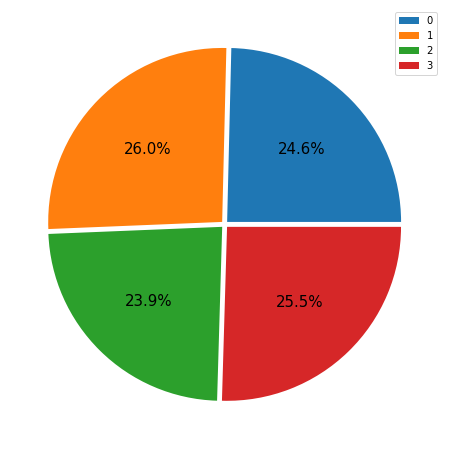

In [7]:
plt.figure(figsize=(12,8))
plt.pie(values,autopct='%1.1f%%', explode = [0.02,0.02,0.02, 0.02], textprops = {"fontsize":15})
plt.legend(labels=data.class_names)
plt.show()

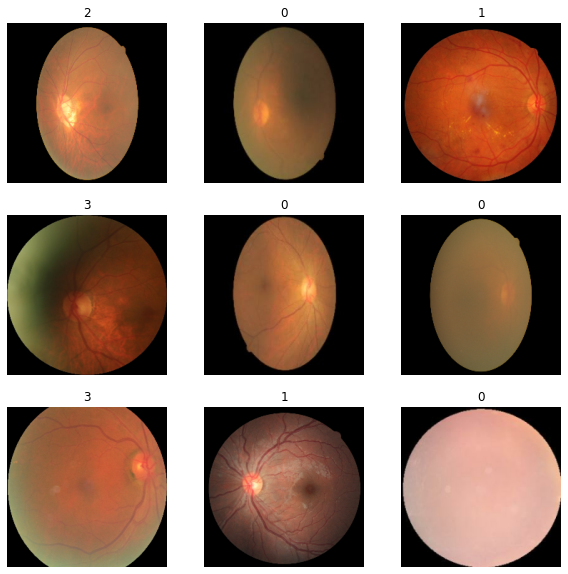

In [8]:
#Displaying some images

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
#Standardize the data

data = data.map(lambda x, y: (x/255, y))
sample = data.as_numpy_iterator().next()
print(sample[0].min())
print(sample[0].max())

0.0
1.0


In [10]:
train_size = int(0.7 * len(data)) +1
val_size = int(0.2 * len(data))
test_size = int(0.1 * len(data))

In [11]:
train = data.take(train_size)
remaining = data.skip(train_size)
val = remaining.take(val_size)
test = remaining.skip(val_size)

In [12]:
test_iter = test.as_numpy_iterator()

test_set = {"images":np.empty((0,224,224,3)), "labels":np.empty(0)}
while True:
  try:
    batch = test_iter.next()
    test_set['images'] = np.concatenate((test_set['images'], batch[0]))
    test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
  except:
    break

In [13]:
# !pip install -q efficientnet

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.applications.xception import Xception, preprocess_input
import tensorflow.keras.layers as Layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax

In [15]:
def create_baselineCNN():
    model = Sequential([
        Conv2D(filters = 64, kernel_size=3, activation = 'relu',padding='same', input_shape=(224,224,3)),
        Conv2D(filters = 64, kernel_size=3, activation = 'relu',padding='same'),
        BatchNormalization(),
        MaxPool2D(2),
        Dropout(0.3),

        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        BatchNormalization(),
        MaxPool2D(2),
        Dropout(0.3),
        
        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        BatchNormalization(),
        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        BatchNormalization(),
        MaxPool2D(2),
        Dropout(0.3),
        
        Flatten(),
        Dense(64, activation = 'relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(128, activation = 'relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(4, activation='softmax')
    ])
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
    return model

In [16]:
from keras import callbacks 
early_stop = callbacks.EarlyStopping(
        monitor="val_accuracy", 
        patience=20,
        verbose=1,
        mode="max",
        restore_best_weights=True, 
     )

with tf.device('/GPU:0'):
    model = create_baselineCNN()
    history = model.fit(
        train,
        validation_data=val,
        epochs = 50,
        callbacks=[early_stop],
    )

Epoch 1/50
47/47 [==============================] - 29s 473ms/step - loss: 1.3890 - accuracy: 0.4129 - val_loss: 4.1264 - val_accuracy: 0.2416
Epoch 2/50
47/47 [==============================] - 24s 479ms/step - loss: 1.0265 - accuracy: 0.5376 - val_loss: 8.0210 - val_accuracy: 0.2356
Epoch 3/50
47/47 [==============================] - 24s 486ms/step - loss: 0.8801 - accuracy: 0.5954 - val_loss: 8.6542 - val_accuracy: 0.2464
Epoch 4/50
47/47 [==============================] - 24s 481ms/step - loss: 0.7717 - accuracy: 0.6499 - val_loss: 10.2295 - val_accuracy: 0.2452
Epoch 5/50
47/47 [==============================] - 24s 479ms/step - loss: 0.7083 - accuracy: 0.6975 - val_loss: 11.2545 - val_accuracy: 0.2704
Epoch 6/50
47/47 [==============================] - 24s 480ms/step - loss: 0.6704 - accuracy: 0.7207 - val_loss: 8.9737 - val_accuracy: 0.2488
Epoch 7/50
47/47 [==============================] - 24s 486ms/step - loss: 0.6394 - accuracy: 0.7287 - val_loss: 7.0571 - val_accuracy: 0.24

In [ ]:
model.summary()

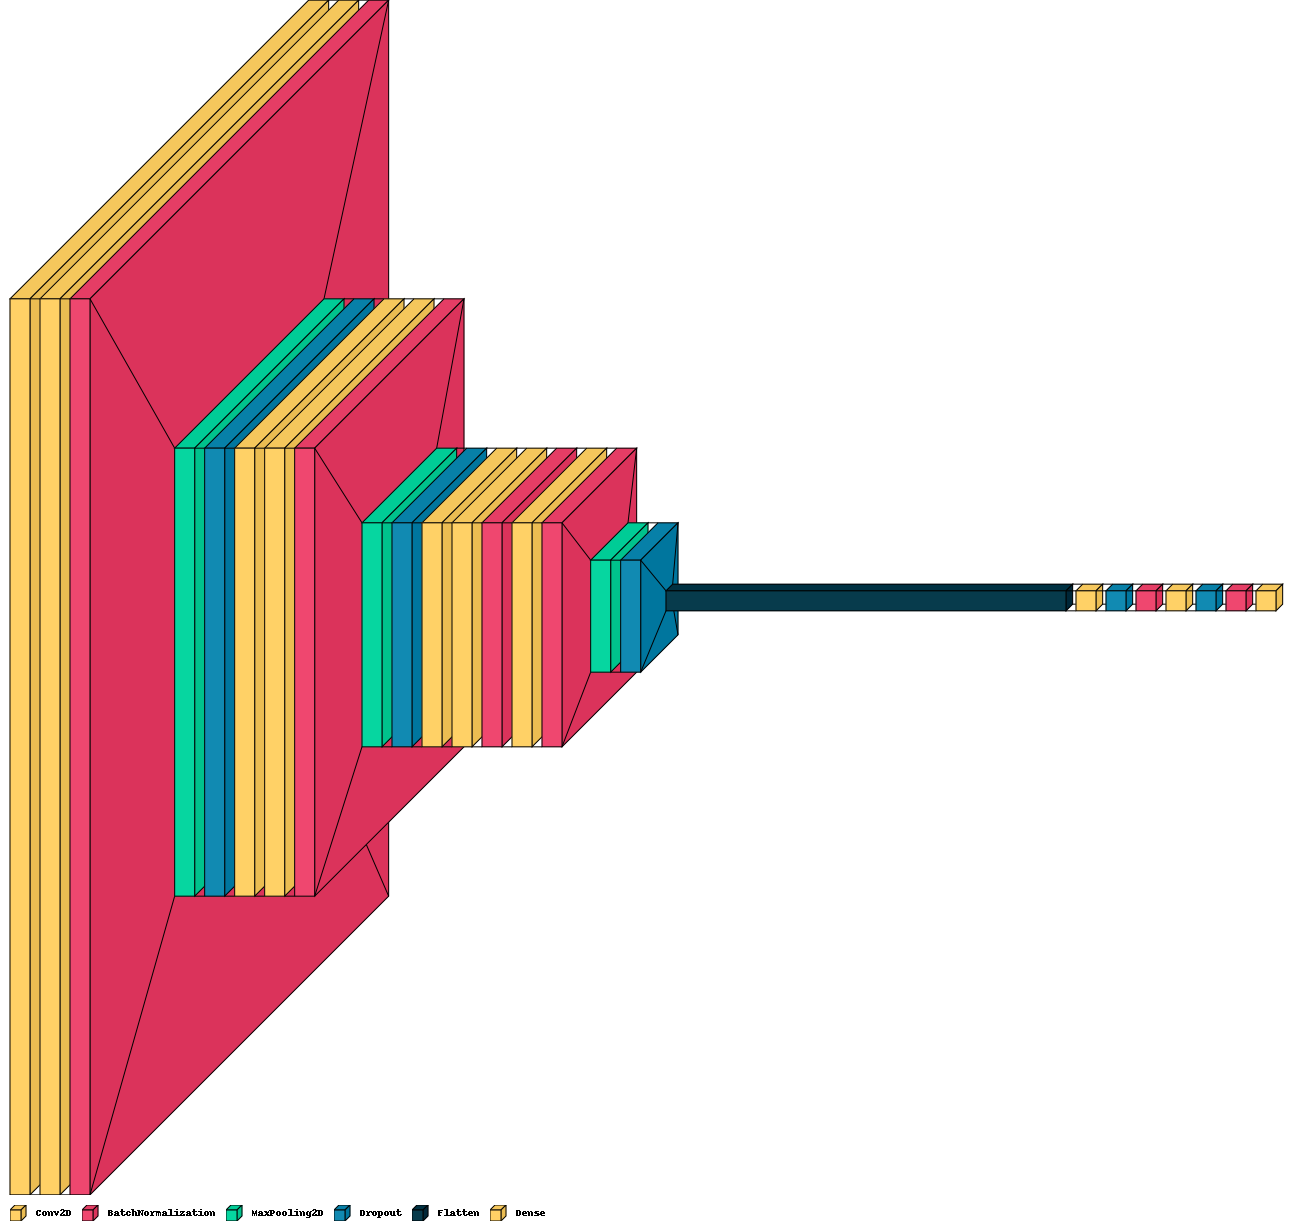

In [17]:
visualkeras.layered_view(model,legend=True)

In [18]:
model.save('Test_2_CNN.h5')

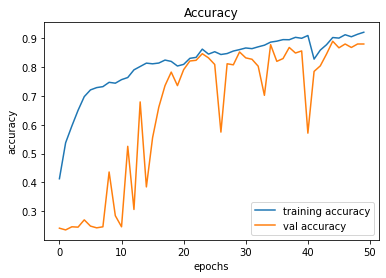

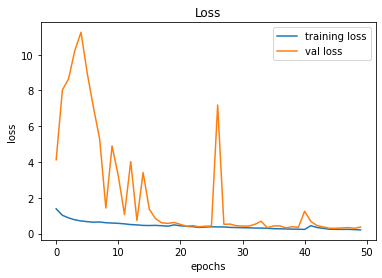

In [19]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [20]:
pred = np.argmax(model.predict(test_set['images']), 1)

In [21]:
actual = test_set['labels']

In [22]:
print(accuracy_score(actual, pred))

0.870026525198939


In [23]:
label = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [24]:
cf = classification_report(actual, pred, target_names = label)
print(cf)

                      precision    recall  f1-score   support

            cataract       0.84      0.91      0.88        94
diabetic_retinopathy       0.99      1.00      0.99        98
            glaucoma       0.93      0.62      0.75        90
              normal       0.76      0.93      0.83        95

            accuracy                           0.87       377
           macro avg       0.88      0.87      0.86       377
        weighted avg       0.88      0.87      0.87       377



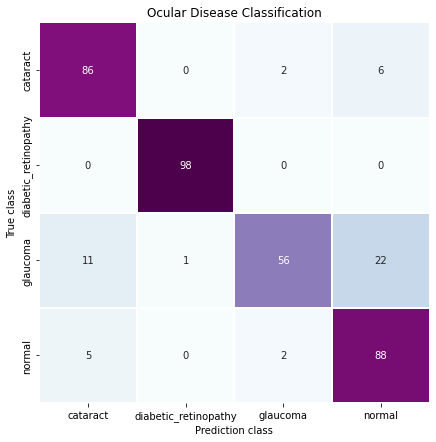

In [25]:
cm = confusion_matrix(actual, pred)
cm_df = pd.DataFrame(cm, index = label, columns = label)

plt.figure(figsize = (7,7))
sns.heatmap(cm_df, annot = True,cmap='BuPu',cbar=False,linewidth=2,fmt='d')
plt.title('Ocular Disease Classification')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()

In [31]:
def make_model():
    Xcept = Xception(include_top=False, weights="imagenet",input_shape=(224,224,3), pooling='max') 
    Xcept.trainable=False
    
    for layer in Xcept.layers[83:]:
      layer.trainable=True
    
    x = Xcept.output
    x = BatchNormalization()(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x = Dropout(rate=.45, seed=2022)(x)        
    output=Dense(4, activation='softmax')(x)
    
    model= tf.keras.Model(inputs=Xcept.input, outputs=output)
    model.compile(optimizer = 'adamax', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
    return model

In [32]:
early_stop = callbacks.EarlyStopping(
        monitor="val_accuracy", 
        patience=10,
        verbose=1,
        mode="max",
        restore_best_weights=True, 
     )

with tf.device('/GPU:0'):
    model = make_model()
    history = model.fit(
        train,
        validation_data=val,
        epochs = 50,
        callbacks=[early_stop],
    )

83689472/83683744 [==============================] - 36s 0us/step
Epoch 1/50
47/47 [==============================] - 23s 399ms/step - loss: 7.7647 - accuracy: 0.7743 - val_loss: 6.9707 - val_accuracy: 0.5264
Epoch 2/50
47/47 [==============================] - 19s 386ms/step - loss: 5.8066 - accuracy: 0.9109 - val_loss: 5.7883 - val_accuracy: 0.8173
Epoch 3/50
47/47 [==============================] - 20s 399ms/step - loss: 4.6628 - accuracy: 0.9558 - val_loss: 4.9012 - val_accuracy: 0.9038
Epoch 4/50
47/47 [==============================] - 20s 394ms/step - loss: 3.8150 - accuracy: 0.9777 - val_loss: 4.1079 - val_accuracy: 0.9195
Epoch 5/50
47/47 [==============================] - 19s 382ms/step - loss: 3.1327 - accuracy: 0.9884 - val_loss: 3.4902 - val_accuracy: 0.9135
Epoch 6/50
47/47 [==============================] - 19s 374ms/step - loss: 2.5877 - accuracy: 0.9940 - val_loss: 2.9160 - val_accuracy: 0.9411
Epoch 7/50
47/47 [==============================] - 18s 363ms/step - loss: 2

In [33]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [34]:
model.save('Test_2_CNN+Xception.h5')

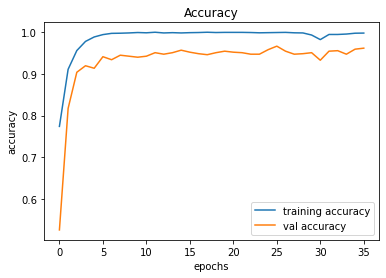

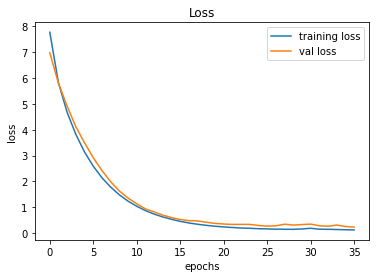

In [35]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [36]:
pred = np.argmax(model.predict(test_set['images']), 1)

In [37]:
print(accuracy_score(actual, pred))

0.9522546419098143


In [38]:
cf = classification_report(actual, pred, target_names = label)
print(cf)

                      precision    recall  f1-score   support

            cataract       0.95      0.98      0.96        94
diabetic_retinopathy       1.00      1.00      1.00        98
            glaucoma       0.96      0.86      0.91        90
              normal       0.90      0.97      0.93        95

            accuracy                           0.95       377
           macro avg       0.95      0.95      0.95       377
        weighted avg       0.95      0.95      0.95       377



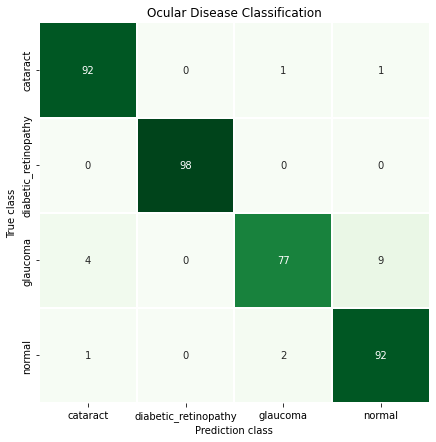

In [39]:
cm = confusion_matrix(actual, pred)
cm_df = pd.DataFrame(cm, index = label, columns = label)

plt.figure(figsize = (7,7))
sns.heatmap(cm_df, annot = True,cmap='Greens',cbar=False,linewidth=2,fmt='d')
plt.title('Ocular Disease Classification')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()